# Visualization - Property Layer Visualization


### The Boltzmann Wealth Model 

### Import Dependencies
This includes importing of dependencies needed for the tutorial.

In [1]:
# Has multi-dimensional arrays and matrices.
# Has a large collection of mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.discrete_space.property_layer import PropertyLayer

# Check Mesa version for visualization compatibility
if mesa.__version__.startswith(("3.0", "3.1", "3.2")):
    print(
        f"⚠️  Mesa {mesa.__version__} detected. Visualization features require Mesa 3.3+"
    )
    print("To upgrade: pip install --upgrade mesa")

from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle, PropertyLayerStyle

## Basic Model

The following is the base model we'll use to build the dashboard. It's an extension of the model introduced in Tutorials 0–3, with an added property layer called _Test Layer_ to demonstrate property layer visualization functionalities.

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, cell):
        """initialize a MoneyAgent instance.

        Args:
            model: A model instance
        """
        super().__init__(model)
        self.cell = cell
        self.wealth = 1

    def move(self):
        """Move the agent to a random neighboring cell."""
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        """Give 1 unit of wealth to a random agent in the same cell."""
        cellmates = [a for a in self.cell.agents if a is not self]

        if cellmates:  # Only give money if there are other agents present
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        """do one step of the agent."""
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n=10, width=10, height=10, rng=None):
        """Initialize a MoneyModel instance.

        Args:
            N: The number of agents.
            width: Width of the grid.
            height: Height of the grid.
        """
        super().__init__(rng=rng)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # Add a test property layer with random data
        test_layer = PropertyLayer(
            "test layer", (width, height), default_value=0, dtype=int
        )
        test_layer.data = np.random.randint(0, 10, size=(width, height))
        self.grid.add_property_layer(test_layer)

        # Create agents
        MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
        self.datacollector.collect(self)

    def step(self):
        """do one step of the model"""
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

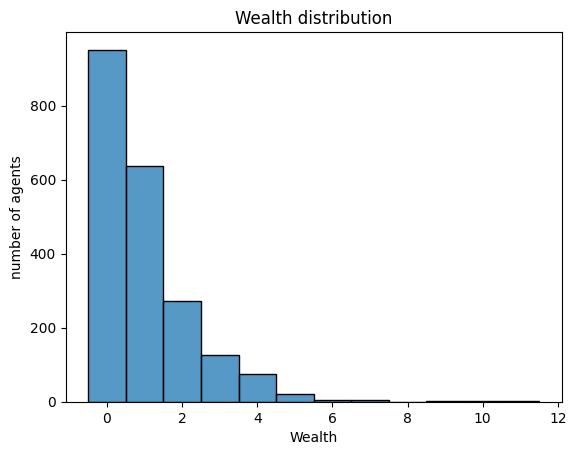

In [3]:
# Let's make sure the model works
model = MoneyModel(100, 10, 10)
model.run_for(20)


data = model.datacollector.get_agent_vars_dataframe()
# Use seaborn
g = sns.histplot(data["Wealth"], discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

### Adding visualization

So far, we've built a model, run it, and analyzed some output afterwards. However, one of the advantages of agent-based models is that we can often watch them run step by step, potentially spotting unexpected patterns, behaviors or bugs, or developing new intuitions, hypotheses, or insights. Other times, watching a model run can explain it to an unfamiliar audience better than static explanations. Like many ABM frameworks, Mesa allows you to create an interactive visualization of the model. In this section we'll walk through creating a visualization using built-in components, and (for advanced users) how to create a new visualization element.

First, a quick explanation of how Mesa's interactive visualization works. The visualization is done in a browser window or Jupyter instance, using the [Solara](https://solara.dev/) framework, a pure Python, React-style web framework. Running `solara run app.py` will launch a web server, which runs the model, and displays model detail at each step via a plotting library. Alternatively, you can execute everything inside a Jupyter instance and display it inline.

As in the previous tutorial we instantiate the model parameters, some of which are modifiable by user inputs. In this case, the number of agents, N, is specified as a slider of integers.

In [4]:
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

Then just like last time we instantiate the visualization object which (by default) displays the grid containing the agents, and timeseries of values computed by the model's data collector. In this example, we specify the Gini coefficient.

There are 3 buttons:
- the step button, which advances the model by 1 step
- the play button, which advances the model indefinitely until it is paused
- the pause button, which pauses the model

To reset the model, the order of operations are important
1. Stop the model
2. Update the parameters (e.g. move the sliders)
3. Press reset 

**Additional Interactive Controls**

In addition to the basic controls (Play, Pause, Step), there are three extra interactive UI elements that give you more control over the simulation and visualization performance:

1. **Play Interval Slider**
   This slider controls the time delay (in milliseconds) between each step of the simulation when it is playing.

   * **Lower values** = faster simulation updates
   * **Higher values** = slower, more observable step-by-step updates

2. **Render Interval Slider**
   This slider determines how frequently the visualization updates, based on the number of steps.

   * For example, if set to `5`, the visualization will update only **after every 5 steps** of the model.
   * ⚠️ Note: This interval is **step-based**, not time-based.

3. **Use Threads Checkbox**
   This checkbox enables threaded execution of the model.

   * When enabled, the visualization runs on a separate thread, allowing the UI to remain responsive even during heavy computations.
   * It also ensures the visualization only updates at fixed intervals, improving performance and responsiveness during rapid simulations.

### Page Tab View

#### **Plot Components**
You can place different components (except the renderer) on separate pages according to your preference. There are no restrictions on page numbering — pages do not need to be sequential or positive. Each page acts as an independent window where components may or may not exist.

The default page is `page=0`. If pages are not sequential (e.g., `page=1` and `page=10`), the system will automatically create the 8 empty pages in between to maintain consistent indexing. To avoid empty pages in your dashboard, use sequential page numbers.

To assign a plot component to a specific page, pass the `page` keyword argument to `make_plot_component`. For example, the following will display the plot component on page 1:

```python
plot_comp = make_plot_component("encoding", page=1)
```

#### **Custom Components**
In the next tutorial, you will learn how to create custom components for the Solara dashboard. If you want a custom component to appear on a specific page, you must pass it as a tuple containing the component and the page number.

```python
@solara.component
def CustomComponent():
    ...

page = SolaraViz(
    model,
    renderer,
    components=[(CustomComponent, 1)]  # Custom component will appear on page 1
)
```

> ⚠️ **Warning**
> Running the model can be performance-intensive. It is strongly recommended to pause the model in the dashboard before switching pages.

## Visualizing Property Layers

> **⚠️ Important:**
> Property layer visualization on `HexGrid` is not supported with the `altair` backend; use `matplotlib` instead.

You can visualize **property layers** in a way that's very similar to how agents are visualized—by defining a custom portrayal function. Let’s call this function `propertylayer_portrayal`.

Mesa provides a dedicated component for property layer styling, called `PropertyLayerStyle` (similar to `AgentPortrayalStyle` for agents). You can import it from `mesa.visualization.components` as shown earlier.

In `PropertyLayerStyle`, you can define:

* `color` or `colormap`: Determines how the values in the layer are visualized
* `alpha`: Controls the transparency (opacity) of the layer
* `colorbar`: A boolean that determines whether a colorbar is shown alongside the visualization
* `vmin` and `vmax`: The minimum and maximum data values to be visualized, controlling the color scale range, these default to the minimum and maximum values in your data respectively if not defined.

The portrayal function receives a `layer` object as an argument, just like how `agent_portrayal` receives an `agent`. If your model includes multiple property layers, you can conditionally adjust the visualization logic based on the `layer.name` field. This allows you to apply different styles to each layer as needed.

Here’s a quick example:

```python
def propertylayer_portrayal(layer):
    if layer.name == "WealthDensity":
        return PropertyLayerStyle(
            colormap="viridis",
            alpha=0.6,
            colorbar=True,
            vmin=0,
            vmax=10,
        )
    elif layer.name == "Temperature":
        return PropertyLayerStyle(
            colormap="coolwarm",
            alpha=0.5,
            colorbar=False,
            vmin=-1,
            vmax=1,
        )
```

This approach allows you to customize each property layer’s appearance independently while keeping your visualization code clean and modular.

We’ll reuse the previously defined `agent_portrayal` function and introduce a new `propertylayer_portrayal` function specifically for visualizing the property layer.

In [5]:
def agent_portrayal(agent):
    portrayal = AgentPortrayalStyle(size=50, color="orange")
    if agent.wealth > 0:
        portrayal.update(("color", "blue"), ("size", 100))
    return portrayal


def propertylayer_portrayal(layer):
    if layer.name == "test layer":
        return PropertyLayerStyle(color="blue", alpha=0.8, colorbar=True)


# Create initial model instance
money_model = MoneyModel(n=50, width=10, height=10)

##### Drawing the Property Layers
We’ll now create a renderer and draw the grid structure, the agents and the _test layer_ using the `matplotlib` backend.

In [6]:
%%capture

renderer = SpaceRenderer(model=money_model, backend="matplotlib")
renderer.draw_structure(lw=2, ls="solid", color="black", alpha=0.1)
renderer.draw_agents(agent_portrayal)
renderer.draw_propertylayer(propertylayer_portrayal)

You can also use `render()` function to draw property layers in one go.

In [7]:
%%capture

renderer = SpaceRenderer(model=money_model, backend="matplotlib")
renderer.render(
    space_kwargs={  # an alternative way to customize the grid structure
        "lw": 2,
        "ls": "solid",
        "color": "black",
        "alpha": 0.1,
    },
    agent_portrayal=agent_portrayal,
    propertylayer_portrayal=propertylayer_portrayal,
)

We'll keep the `post_process` to make the grid look good.

In [8]:
def post_process(ax):
    """Customize the matplotlib axes after rendering."""
    ax.set_title("Boltzmann Wealth Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_aspect("equal", adjustable="box")


renderer.post_process = post_process


def post_process_lines(ax):
    """Customize the matplotlib axes for the Gini line plot."""
    ax.set_title("Gini Coefficient Over Time")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Gini Coefficient")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_aspect("auto")


GiniPlot = make_plot_component("Gini", post_process=post_process_lines)

##### Launching the Visualization
Now that we have the model, visual renderer, and plot components defined, we can bring everything together using `SolaraViz`:

In [9]:
page = SolaraViz(
    money_model,
    renderer,
    components=[GiniPlot],
    model_params=model_params,
    name="Boltzmann Wealth Model",
)

# This is required to render the visualization in a Jupyter notebook
page

Cannot show ipywidgets in text

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.” arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.